A corriger dans le process etl
- format datime : soit formart UTC soit format ns
- renommer les deux colonnes en df_transport = df_transport.rename(columns={'datetime_rounded': 'timestamp_rounded'})

In [1]:
import pandas as pd
import requests
import json
import os
import io
from dotenv import load_dotenv
import logging
from sqlalchemy import create_engine, text
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    f1_score,
    precision_score,
    recall_score,
    root_mean_squared_error
)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

load_dotenv()

True

In [2]:
db_url = os.getenv("DATABASE_URL")

In [3]:
engine = create_engine(
    db_url,
    pool_pre_ping=True,
)

with engine.connect() as conn:
    result_transport = conn.execute(text("SELECT * FROM stg_transport_archive"))
    transport_data = result_transport.mappings().all()  # liste de dictionnaires

    result_weather = conn.execute(text("SELECT * FROM stg_weather_archive"))
    weather_data = result_weather.mappings().all()  # liste de dictionnaires

    

In [4]:
"""BASE_DIR = os.getcwd() 

DATA_DIR = os.path.join(BASE_DIR, "..","data")
json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_3_days.json")
#json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_any_days.json")

if not os.path.exists(json_path):
    print(f"Dossier actuel de recherche : {BASE_DIR}")
    raise FileNotFoundError(f"Le fichier {json_path} est introuvable.")

with open(json_path, 'r', encoding='utf-8') as f:
    transport_data = json.load(f)"""

'BASE_DIR = os.getcwd() \n\nDATA_DIR = os.path.join(BASE_DIR, "..","data")\njson_path = os.path.join(DATA_DIR, "transport_koda_one_bus_3_days.json")\n#json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_any_days.json")\n\nif not os.path.exists(json_path):\n    print(f"Dossier actuel de recherche : {BASE_DIR}")\n    raise FileNotFoundError(f"Le fichier {json_path} est introuvable.")\n\nwith open(json_path, \'r\', encoding=\'utf-8\') as f:\n    transport_data = json.load(f)'

In [5]:
df_transport = pd.DataFrame(transport_data)
df_transport.describe()

,arrival_delay,departure_delay,direction_id,hour,id,stop_sequence
count,81568.000000,81568.000000,81576.000000,81576.000000,81576.000000,81576.000000
mean,73.892066,85.766710,0.500000,13.253457,123372.500000,18.500000
std,157.970798,154.199531,0.500003,5.467750,23549.107117,10.388358
min,-752.000000,-530.000000,0.000000,0.000000,82585.000000,1.000000
25%,-7.000000,0.000000,0.000000,9.000000,102978.750000,9.750000
50%,53.000000,61.000000,0.500000,14.000000,123372.500000,18.500000
75%,145.000000,153.000000,1.000000,18.000000,143766.250000,27.250000
max,4900.000000,4911.000000,1.000000,23.000000,164160.000000,36.000000


In [6]:
df_weather = pd.DataFrame(weather_data)
df_weather.sample(20)
df_weather.describe()

,cloud_cover,day_of_week,dew_point_2m,est_jour_ferie,est_weekend,month,neige_fondue,precipitation,rain,risque_gel_neige,...,snowfall,soleil_leve,temperature_2m,timestamp_rounded,vacances_scolaires,weather_code,wind_direction_10m,wind_gusts_10m,wind_speed_10m,year
count,17640.000000,17640.000000,17640.000000,17640.000000,17640.000000,17640.000000,17640.000000,17640.000000,17640.000000,17640.000000,...,17640.000000,17640.000000,17640.000000,17640,17640.000000,17640.000000,17640.000000,17640.000000,17640.000000,17640.000000
mean,65.968764,3.000000,4.361344,0.182313,0.285714,6.489796,0.012472,0.068900,0.059484,0.016553,...,0.006607,0.514966,8.086582,2025-01-02 11:30:00,0.304762,9.783673,204.762755,26.258968,12.033311,2024.507483
min,0.000000,0.000000,-19.100000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-17.000000,2024-01-01 00:00:00,0.000000,0.000000,0.000000,1.100000,0.000000,2024.000000
25%,20.000000,1.000000,-0.300000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.900000,2024-07-02 17:45:00,0.000000,1.000000,146.000000,17.300000,7.900000,2024.000000
50%,96.000000,3.000000,4.600000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,7.600000,2025-01-02 11:30:00,0.000000,3.000000,218.000000,24.800000,11.400000,2025.000000
75%,100.000000,5.000000,9.800000,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,14.600000,2025-07-05 05:15:00,1.000000,3.000000,271.000000,34.200000,15.700000,2025.000000
max,100.000000,6.000000,18.900000,1.000000,1.000000,12.000000,1.000000,9.100000,9.100000,1.000000,...,2.170000,1.000000,27.900000,2026-01-04 23:00:00,1.000000,75.000000,360.000000,91.400000,42.000000,2026.000000
std,41.147847,2.000057,6.988281,0.386113,0.451767,3.464136,0.110981,0.317764,0.307254,0.127594,...,0.054753,0.499790,8.021143,NaN,0.460320,19.535566,91.382786,11.976379,5.674414,0.510728


In [7]:
df_transport = pd.DataFrame(transport_data)

#df_transport = df_transport.rename(columns={'datetime_rounded': 'timestamp_rounded'})

# Pour vérifier
print(df_transport.columns)
df_transport.describe(include='all')

Index(['arrival_delay', 'bus_nbr', 'departure_delay', 'direction_id', 'hour',
       'id', 'stop_sequence', 'timestamp_rounded'],
      dtype='object')


,arrival_delay,bus_nbr,departure_delay,direction_id,hour,id,stop_sequence,timestamp_rounded
count,81568.000000,81576,81568.000000,81576.000000,81576.000000,81576.000000,81576.000000,81576
unique,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,541,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,81576,NaN,NaN,NaN,NaN,NaN,NaN
mean,73.892066,NaN,85.766710,0.500000,13.253457,123372.500000,18.500000,2024-10-20 23:06:35.586937600+00:00
min,-752.000000,NaN,-530.000000,0.000000,0.000000,82585.000000,1.000000,2024-03-30 20:00:00+00:00
25%,-7.000000,NaN,0.000000,0.000000,9.000000,102978.750000,9.750000,2024-07-05 11:00:00+00:00
50%,53.000000,NaN,61.000000,0.500000,14.000000,123372.500000,18.500000,2024-10-09 18:00:00+00:00
75%,145.000000,NaN,153.000000,1.000000,18.000000,143766.250000,27.250000,2025-01-26 11:00:00+00:00
max,4900.000000,NaN,4911.000000,1.000000,23.000000,164160.000000,36.000000,2025-07-17 22:00:00+00:00


In [8]:
# 1. Convertir en datetime ET forcer l'UTC pour les deux --> à corriger dans le process etl /!\
df_transport['timestamp_rounded'] = pd.to_datetime(df_transport['timestamp_rounded'], utc=True)
df_weather['timestamp_rounded'] = pd.to_datetime(df_weather['timestamp_rounded'], utc=True)

# 2. Maintenant le merge fonctionnera sans erreur
df_merged = pd.merge(
    df_transport,
    df_weather,
    on="timestamp_rounded",
    how="left"
)

# 3. Suppression des colonnes
#cols_to_drop = ["id", "observation_uuid", "entity_id", "route_id_static", "timestamp", "timestamp_dt", 
#                "trip_id", "route_id", "year", "uv_index", "shortwave_radiation"]

#df_merged = df_merged.drop(columns=cols_to_drop, errors='ignore')

df_merged.sample(20)

,arrival_delay,bus_nbr,departure_delay,direction_id,hour,id,stop_sequence,timestamp_rounded,cloud_cover,day_of_week,...,snowfall,soleil_leve,temperature_2m,uv_index,vacances_scolaires,weather_code,wind_direction_10m,wind_gusts_10m,wind_speed_10m,year
33189,86.0,541,102.0,1,18,115774,4,2024-09-02 18:00:00+00:00,39,0,...,0.0,1,14.2,None,0,1,189,18.7,8.8,2024
26092,-79.0,541,-37.0,0,18,108677,33,2024-07-31 18:00:00+00:00,44,2,...,0.0,1,20.6,None,1,1,325,25.9,10.6,2024
56409,274.0,541,283.0,1,17,138994,14,2024-12-28 17:00:00+00:00,100,5,...,0.0,0,4.9,None,1,3,229,25.2,13.0,2024
3197,-56.0,541,-40.0,1,6,85782,33,2024-04-16 06:00:00+00:00,100,1,...,0.0,1,1.4,None,0,3,7,18.4,9.1,2024
47216,41.0,541,41.0,1,9,129801,10,2024-11-08 09:00:00+00:00,4,4,...,0.0,1,4.3,None,0,0,258,20.5,11.2,2024
6566,80.0,541,88.0,1,19,89151,28,2024-05-02 19:00:00+00:00,100,3,...,0.0,1,8.3,None,0,3,72,19.8,9.4,2024
20945,110.0,541,113.0,0,13,103530,10,2024-07-07 13:00:00+00:00,32,6,...,0.0,1,20.1,None,1,1,223,64.8,31.3,2024
55644,134.0,541,155.0,0,12,138229,8,2024-12-24 12:00:00+00:00,100,1,...,0.0,1,0.8,None,1,3,248,19.8,10.9,2024
79817,-16.0,541,-13.0,0,15,162402,28,2025-06-22 15:00:00+00:00,96,6,...,0.0,1,19.4,None,1,3,174,40.7,15.9,2025
3984,191.0,541,260.0,0,16,86569,8,2024-04-20 16:00:00+00:00,100,5,...,0.0,1,2.2,None,0,3,350,36.7,16.1,2024


In [9]:
df_merged.columns

Index(['arrival_delay', 'bus_nbr', 'departure_delay', 'direction_id', 'hour',
       'id', 'stop_sequence', 'timestamp_rounded', 'cloud_cover',
       'day_of_week', 'dew_point_2m', 'est_jour_ferie', 'est_weekend', 'month',
       'neige_fondue', 'observation_uuid', 'precipitation', 'rain',
       'risque_gel_neige', 'risque_gel_pluie', 'shortwave_radiation',
       'snowfall', 'soleil_leve', 'temperature_2m', 'uv_index',
       'vacances_scolaires', 'weather_code', 'wind_direction_10m',
       'wind_gusts_10m', 'wind_speed_10m', 'year'],
      dtype='object')

# EDA

In [10]:
# ====================
# 1. CHARGEMENT ET NETTOYAGE
# ====================

# Filtrer les données avec transport
df = df_merged[df_merged['departure_delay'].notna()].copy()

print("="*20)
print("EXPLORATION DES DONNÉES - JUSTIFICATION MÉTHODOLOGIQUE")
print("="*20)
print(f"\nNombre total d'observations : {len(df):,}")
print(f"Période couverte : {df['timestamp_rounded'].min()} à {df['timestamp_rounded'].max()}")
print(f"Nombre de jours : {df['timestamp_rounded'].dt.date.nunique()}")

EXPLORATION DES DONNÉES - JUSTIFICATION MÉTHODOLOGIQUE

Nombre total d'observations : 81,568
Période couverte : 2024-03-30 20:00:00+00:00 à 2025-07-17 22:00:00+00:00
Nombre de jours : 439



1. DISTRIBUTION DES RETARDS

Statistiques des retards (en secondes) :
count    81568.000000
mean        85.766710
std        154.199531
min       -530.000000
25%          0.000000
50%         61.000000
75%        153.000000
max       4911.000000
Name: departure_delay, dtype: float64

Médiane : 61.0s
Mode : 0.0s

Répartition par tranches de retard :
delay_category
Avance      24644
0-1 min     16091
1-2 min     14495
2-5 min     20438
5-10 min     5224
>10 min       671
Name: count, dtype: int64

En pourcentage :
delay_category
Avance      30.2
0-1 min     19.7
1-2 min     17.8
2-5 min     25.1
5-10 min     6.4
>10 min      0.8
Name: proportion, dtype: float64


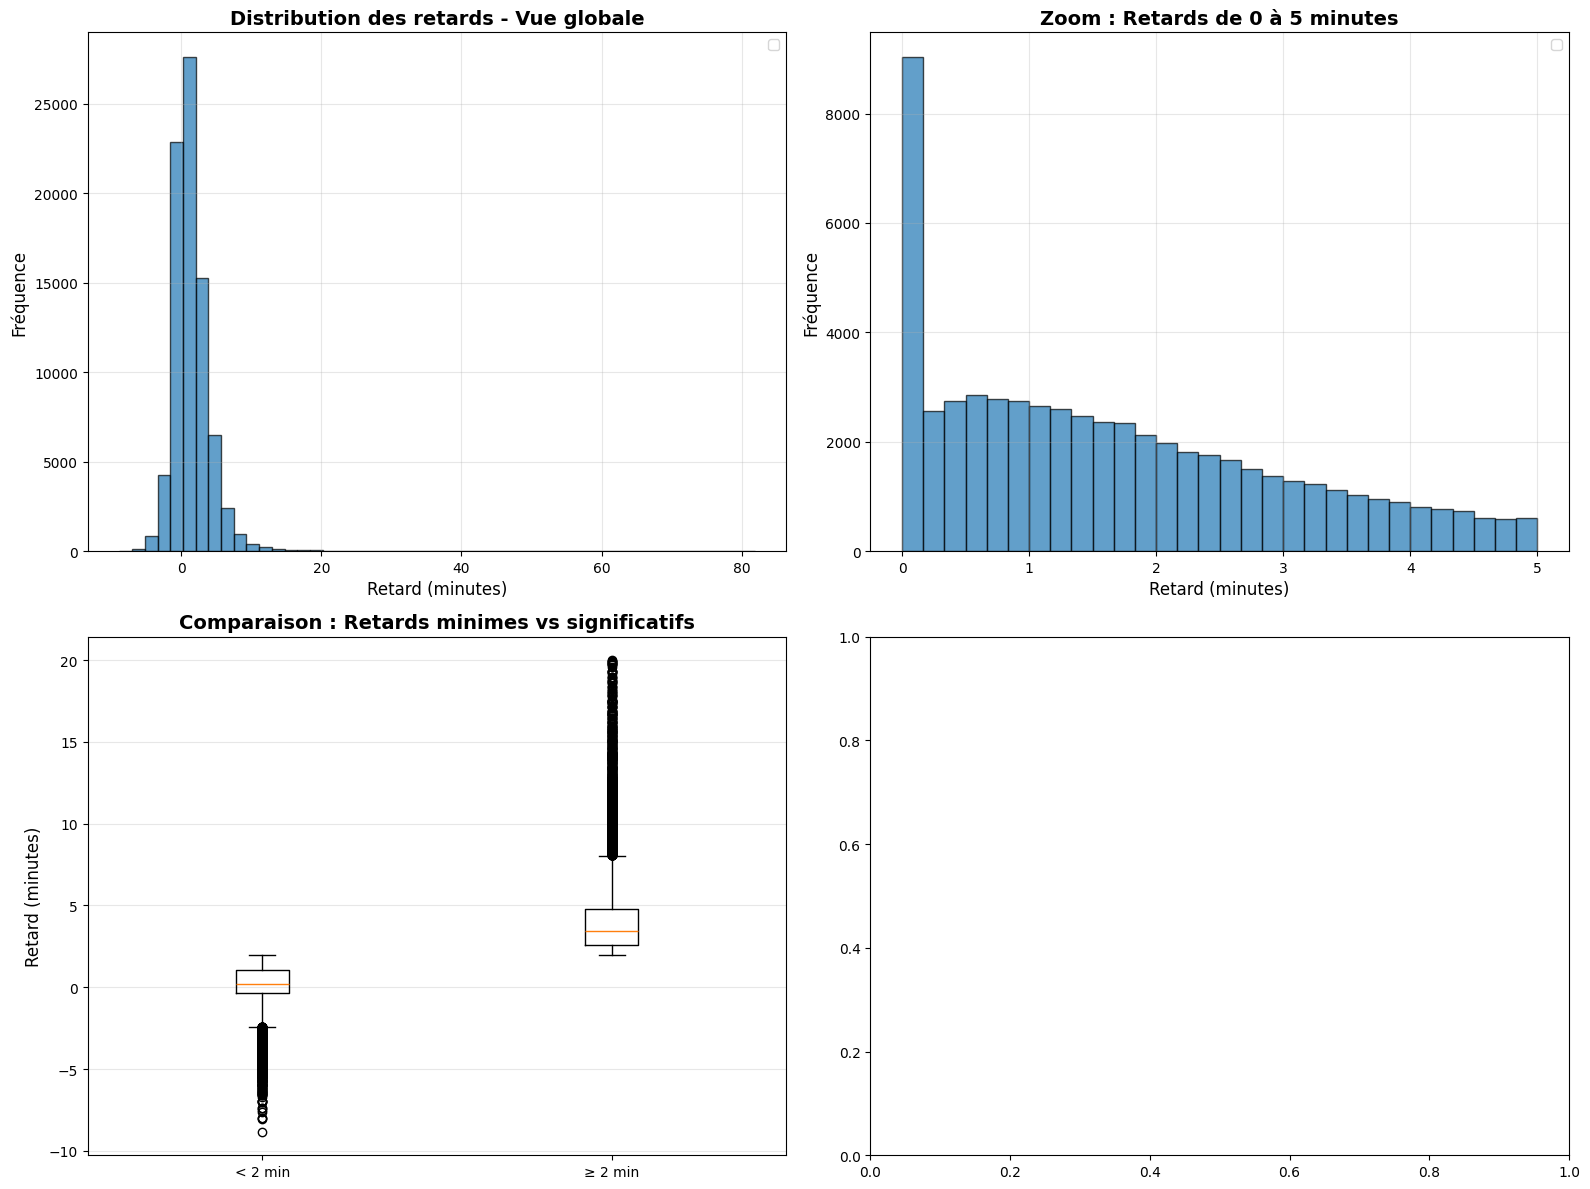

In [11]:
# ====================
# 2. DISTRIBUTION DES RETARDS - ARGUMENT CLÉ
# ====================

print("\n" + "="*20)
print("1. DISTRIBUTION DES RETARDS")
print("="*20)

# Statistiques descriptives
print("\nStatistiques des retards (en secondes) :")
print(df['departure_delay'].describe())
print(f"\nMédiane : {df['departure_delay'].median():.1f}s")
print(f"Mode : {df['departure_delay'].mode().values[0]:.1f}s")

# Conversion en minutes pour lisibilité
df['delay_minutes'] = df['departure_delay'] / 60

# Distribution détaillée par tranches
print("\nRépartition par tranches de retard :")
bins = [-500, 0, 60, 120, 300, 600, 3000]
labels = ['Avance', '0-1 min', '1-2 min', '2-5 min', '5-10 min', '>10 min']
df['delay_category'] = pd.cut(df['departure_delay'], bins=bins, labels=labels)
print(df['delay_category'].value_counts().sort_index())
print("\nEn pourcentage :")
print((df['delay_category'].value_counts(normalize=True)*100).sort_index().round(1))

# GRAPHIQUE 1 : Distribution bimodale
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogramme global
axes[0, 0].hist(df['delay_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Retard (minutes)', fontsize=12)
axes[0, 0].set_ylabel('Fréquence', fontsize=12)
axes[0, 0].set_title('Distribution des retards - Vue globale', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Focus sur les petits retards (0-5 min)
mask_small = (df['delay_minutes'] >= 0) & (df['delay_minutes'] <= 5)
axes[0, 1].hist(df.loc[mask_small, 'delay_minutes'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Retard (minutes)', fontsize=12)
axes[0, 1].set_ylabel('Fréquence', fontsize=12)
axes[0, 1].set_title('Zoom : Retards de 0 à 5 minutes', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Boxplot par catégories
df_boxplot = df[df['delay_minutes'] <= 20]  # Limiter pour visibilité
axes[1, 0].boxplot([df_boxplot[df_boxplot['delay_minutes'] < 2]['delay_minutes'],
                     df_boxplot[df_boxplot['delay_minutes'] >= 2]['delay_minutes']],
                    labels=['< 2 min', '≥ 2 min'])
axes[1, 0].set_ylabel('Retard (minutes)', fontsize=12)
axes[1, 0].set_title('Comparaison : Retards minimes vs significatifs', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

Distribution des retards
- la moitié des trajets ont moins de 1 min 15 de retards (médiane)
- la moyenne est plus élevée que la médiane et est tirée vers le haut par quelques gros retards
- le cas le plus fréquent est qu'il y a 0 retards (voir de l'avance dans 26% des cas !)
- Très grande dispersion (153 s ecart-type)

Distribution : asymétrique, queue lourde, beaucoup de masse autour de 0-180 s

Essais sur détermination d'un seuil : 
Dans une logique "métier", on pourrait penser qu'à partir de 2 min , c'est considéré comme du retards.
sauf, que : 
- 46% des observations sont entre 1 et 5 minutes
- un seuil de 120 s est pile au milieu de la zone la plus dense

c'est exactement la situation où les features changents peu, mais le label change "brutalement"

conclusion : 
- si application d'un seuil `is_delayed = (delay > 120s)` sera intrinsèquement bruitée et aucun modèle de classification pourra faire de "bons résultats"
- il n'existe aucun seuil naturel dans les données de retards entre 0 et 5 minutes
- le problème ne se décompose pas en deux tâches
--> un modèle à deux étages serait donc mal posés

"Le seuil de 2 minutes (ou plus ou moins), bien que pertinent d’un point de vue métier, se situe dans une zone de forte densité de la distribution des retards. Cette proximité induit un bruit de labellisation important, limitant mécaniquement les performances de la classification. Les approches continues (régression) se révèlent plus adaptées à la structure réelle des données."




3. CORRÉLATIONS METEO SELON LE GROUPE

 Corrélations avec departure_delay :
                Sans_retard  Avec_retard  Différence
stop_sequence        -0.391        0.054       0.445
hour                  0.038        0.121       0.083
snowfall             -0.022        0.016       0.037
temperature_2m       -0.029       -0.008       0.022
precipitation        -0.014        0.003       0.017
wind_speed_10m       -0.013        0.003       0.016
cloud_cover          -0.007       -0.028      -0.021


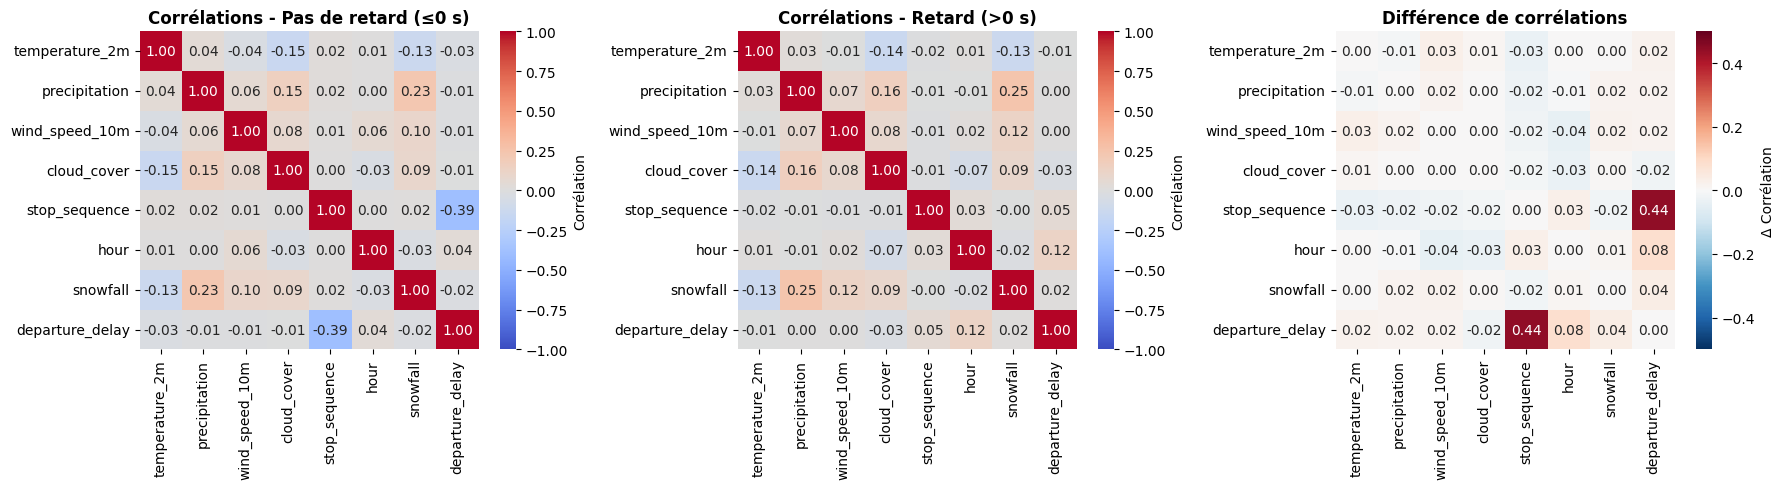

In [12]:
# ============================================================================
# 3. CORRÉLATIONS CONDITIONNELLES
# ============================================================================

print("\n" + "="*20)
print("3. CORRÉLATIONS METEO SELON LE GROUPE")
print("="*20)

SEUIL = 120  # 2 minutes
df['has_delay'] = (df['departure_delay'] > 0).astype(int)

# Calculer corrélations pour chaque groupe
numeric_cols = ['temperature_2m', 'precipitation', 'wind_speed_10m', 
                'cloud_cover', 'stop_sequence', 'hour', 'snowfall']

df_no_delay = df[df['has_delay']==0][numeric_cols + ['departure_delay']].copy()
df_delay = df[df['has_delay']==1][numeric_cols + ['departure_delay']].copy()

corr_no_delay = df_no_delay.corr()['departure_delay'].drop('departure_delay')
corr_delay = df_delay.corr()['departure_delay'].drop('departure_delay')

print("\n Corrélations avec departure_delay :")
corr_comparison = pd.DataFrame({
    'Sans_retard': corr_no_delay,
    'Avec_retard': corr_delay,
    'Différence': corr_delay - corr_no_delay
})
corr_comparison = corr_comparison.sort_values(by='Différence', ascending=False)
print(corr_comparison.round(3))

# GRAPHIQUE 3 : Heatmap comparative
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sans retard
sns.heatmap(df_no_delay.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Corrélation'})
axes[0].set_title('Corrélations - Pas de retard (≤0 s)', fontsize=12, fontweight='bold')

# Avec retard
sns.heatmap(df_delay.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Corrélation'})
axes[1].set_title('Corrélations - Retard (>0 s)', fontsize=12, fontweight='bold')

# Différence
diff_matrix = df_delay.corr() - df_no_delay.corr()
sns.heatmap(diff_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-0.5, vmax=0.5, ax=axes[2], cbar_kws={'label': 'Δ Corrélation'})
axes[2].set_title('Différence de corrélations', fontsize=12, fontweight='bold')

plt.tight_layout()


4. PATTERNS TEMPORELS - Justification de features temporelles

Retards par heure de la journée :
    hour  prob_retard  retard_moyen
0      0         0.77        110.46
1      1         0.64        180.69
2      3         0.75         69.11
3      4         0.71         57.76
4      5         0.64         44.74
5      6         0.64         51.79
6      7         0.67         61.89
7      8         0.63         50.48
8      9         0.62         48.52
9     10         0.68         72.68
10    11         0.71         84.97
11    12         0.71         93.79
12    13         0.70         93.37
13    14         0.68         91.40
14    15         0.70        102.77
15    16         0.68         93.90
16    17         0.72        100.08
17    18         0.75        108.54
18    19         0.76        118.95
19    20         0.74        109.90
20    21         0.73         99.83
21    22         0.75        100.97
22    23         0.77        111.39


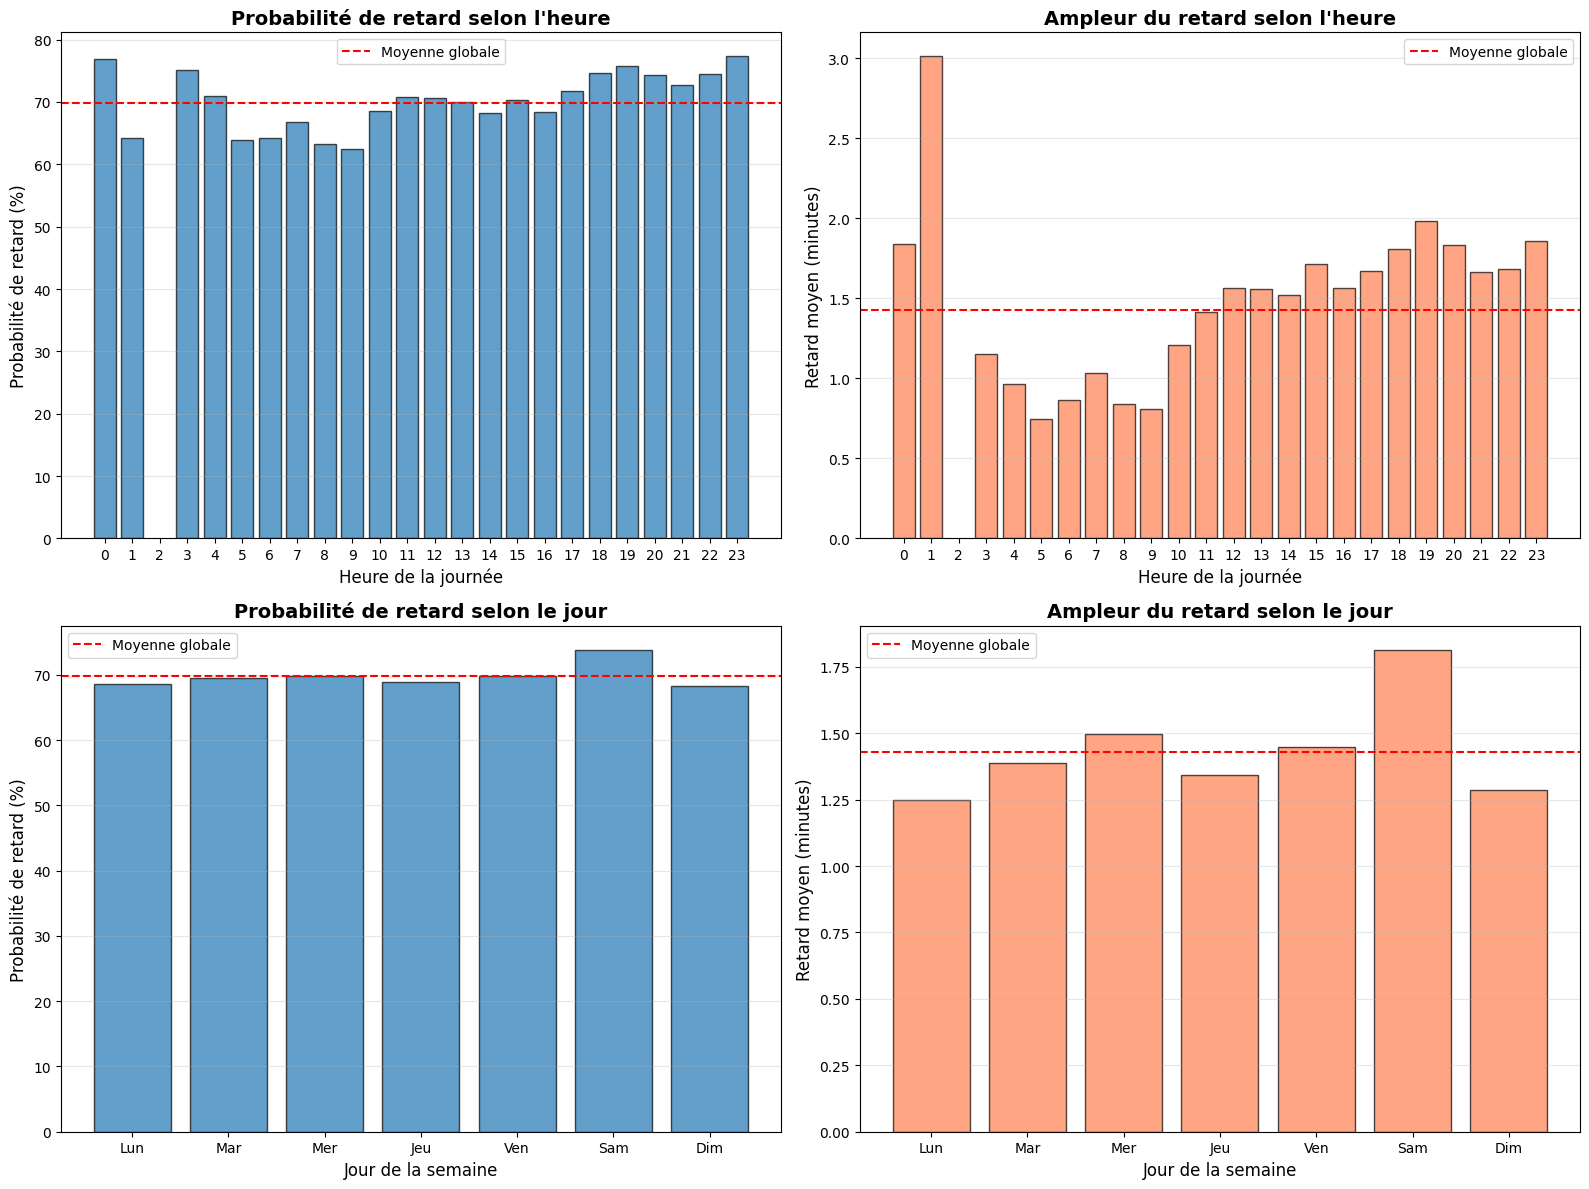

In [13]:
# =====================
# 5. PATTERNS TEMPORELS
# =====================

print("\n" + "="*20)
print("4. PATTERNS TEMPORELS - Justification de features temporelles")
print("="*20)

# Par heure
delay_by_hour = df.groupby('hour').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()
delay_by_hour.columns = ['hour', 'prob_retard', 'retard_moyen']

print("\nRetards par heure de la journée :")
print(delay_by_hour.round(2))

# Par jour de la semaine
delay_by_dow = df.groupby('day_of_week').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()
delay_by_dow.columns = ['day_of_week', 'prob_retard', 'retard_moyen']
delay_by_dow['day_name'] = delay_by_dow['day_of_week'].map({
    0: 'Lun', 1: 'Mar', 2: 'Mer', 3: 'Jeu', 4: 'Ven', 5: 'Sam', 6: 'Dim'
})

# GRAPHIQUE 4 : Patterns temporels
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1- Probabilité de retard par heure
axes[0, 0].bar(delay_by_hour['hour'], delay_by_hour['prob_retard']*100, 
               edgecolor='black', alpha=0.7)
axes[0, 0].axhline(df['has_delay'].mean()*100, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[0, 0].set_xlabel('Heure de la journée', fontsize=12)
axes[0, 0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[0, 0].set_title('Probabilité de retard selon l\'heure', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_xticks(range(24))

# 2- Ampleur moyenne par heure
axes[0, 1].bar(delay_by_hour['hour'], delay_by_hour['retard_moyen']/60, 
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axhline(df['departure_delay'].mean()/60, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[0, 1].set_xlabel('Heure de la journée', fontsize=12)
axes[0, 1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[0, 1].set_title('Ampleur du retard selon l\'heure', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(range(24))

# 3- Par jour de la semaine - Probabilité
axes[1, 0].bar(delay_by_dow['day_name'], delay_by_dow['prob_retard']*100, 
               edgecolor='black', alpha=0.7)
axes[1, 0].axhline(df['has_delay'].mean()*100, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[1, 0].set_xlabel('Jour de la semaine', fontsize=12)
axes[1, 0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[1, 0].set_title('Probabilité de retard selon le jour', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4- Par jour de la semaine - Ampleur
axes[1, 1].bar(delay_by_dow['day_name'], delay_by_dow['retard_moyen']/60, 
               color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].axhline(df['departure_delay'].mean()/60, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[1, 1].set_xlabel('Jour de la semaine', fontsize=12)
axes[1, 1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[1, 1].set_title('Ampleur du retard selon le jour', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

- `prob_retard` (probabilité d’avoir un retard > 0 s)
- `retard_moyen` (intensité du retard)

- Heures à risque de retards élevé : 0h, 18h-23h --> `prob_retard` = 0.45-0.47 // `retard_moyen` = 125-138s
- Heures 'fluides : 4h-6h --> `prob_retard` = 0.22-0.24 // `retard_moyen` = 60s

Malgré ces écarts : 
- la variation est progressive
- pas d'heure charnières où le système change brutalement


5. IMPACT MÉTÉO - Différent selon qu'il y a retard ou non

 Retards selon les conditions météo :
              Nombre  Prob_retard  Retard_moyen_sec  Retard_moyen_min
weather_code                                                         
Bruine          8829         0.68             79.29          1.321500
Ciel clair     21691         0.71             93.36          1.556000
Neige           1694         0.70             92.87          1.547833
Nuageux        48382         0.70             83.54          1.392333
Pluie            972         0.64             73.64          1.227333


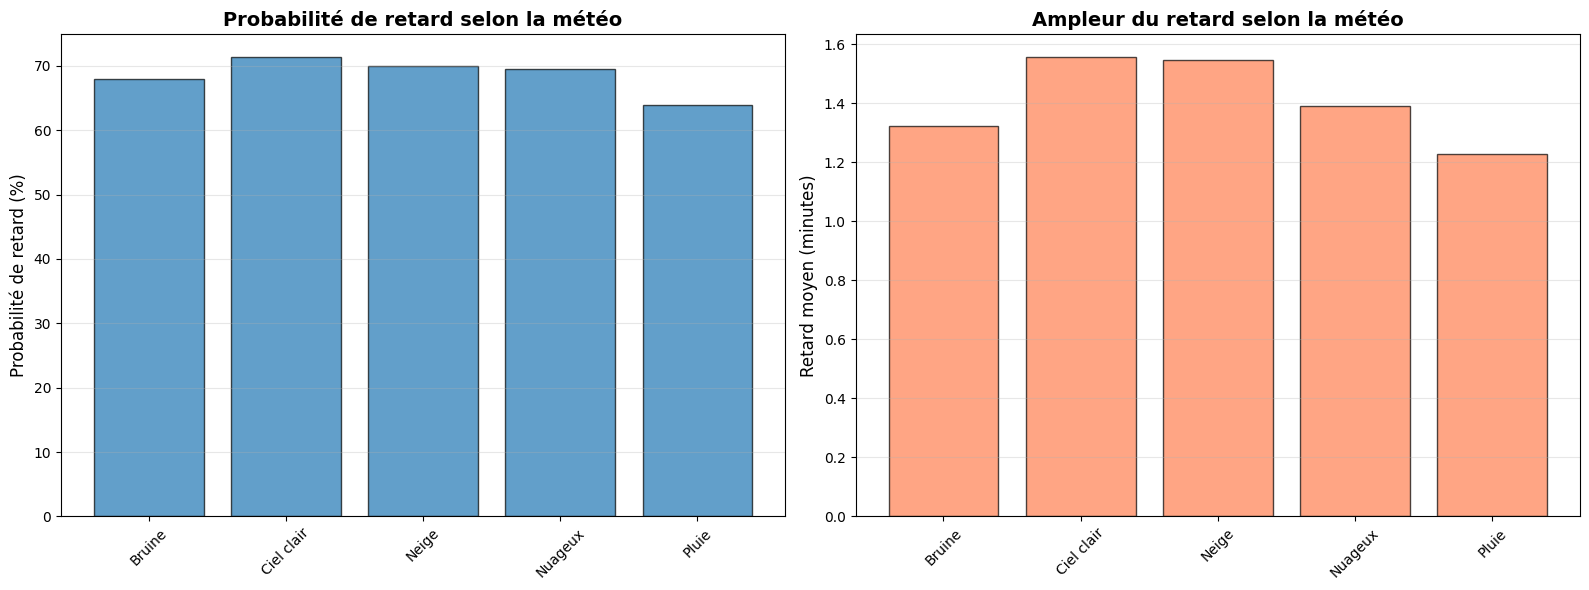

In [14]:
# ========================================
# 6. IMPACT MÉTÉO - VISION CONDITIONNELLE
# =======================================

print("\n" + "="*20)
print("5. IMPACT MÉTÉO - Différent selon qu'il y a retard ou non")
print("="*20)

# Catégoriser la météo
df.loc[df['weather_code'].isin([61, 63, 65]), 'weather_code'] = 'Pluie'
df.loc[df['weather_code'].isin([71, 73, 75]), 'weather_code'] = 'Neige'
df.loc[df['weather_code'].isin([51, 53, 55]), 'weather_code'] = 'Bruine'
df.loc[df['weather_code'].isin([1, 2, 3]), 'weather_code'] = 'Nuageux'
df.loc[df['weather_code'].isin([0]), 'weather_code'] = 'Ciel clair'

print("\n Retards selon les conditions météo :")
meteo_impact = df.groupby('weather_code').agg({
    'has_delay': ['count', 'mean'],
    'departure_delay': 'mean'
}).round(2)

meteo_impact.columns = ['Nombre', 'Prob_retard', 'Retard_moyen_sec']
meteo_impact['Retard_moyen_min'] = meteo_impact['Retard_moyen_sec'] / 60
print(meteo_impact)

# GRAPHIQUE 5 : Impact météo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

meteo_stats = df.groupby('weather_code').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()

axes[0].bar(meteo_stats['weather_code'], meteo_stats['has_delay']*100, 
            edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[0].set_title('Probabilité de retard selon la météo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(meteo_stats['weather_code'], meteo_stats['departure_delay']/60, 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[1].set_title('Ampleur du retard selon la météo', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

- la météo a un effet réel mai smodéré
- elle ne crée par d'effet "ctastrophe" (sauf cas extrêmes)

- Différence de 30-40 s max
- Pas de rupture

In [15]:
# Statistiques finales
print("\n Statistiques finales :")
print(f"  Nombre total d'observations : {len(df):}")
print(f"  Retard moyen global : {df['departure_delay'].mean()/60:.2f} minutes")
print(f"  Retard moyen si retard >0 s : {df[df['has_delay']==1]['departure_delay'].mean()/60:.2f} minutes")
print(f"  Écart-type global : {df['departure_delay'].std()/60:.2f} minutes")
print(f"  Écart-type si retard >0 s : {df[df['has_delay']==1]['departure_delay'].std()/60:.2f} minutes")

print("\n" + "="*20)
print("EXPLORATION TERMINÉE")
print("="*20)


 Statistiques finales :
  Nombre total d'observations : 81568
  Retard moyen global : 1.43 minutes
  Retard moyen si retard >0 s : 2.43 minutes
  Écart-type global : 2.57 minutes
  Écart-type si retard >0 s : 2.36 minutes

EXPLORATION TERMINÉE


## Synthèse 

### Synthèse

L'EDA suggère que : 
- le retard est le résultat de micro-perturbations cumulées
- pas d’“événement déclencheur” clair avant 5–10 min
- chaque minute supplémentaire est juste un peu moins probable
- la météo a un effet sur la moyenne mais n'a pas un effet de modification du changement d'état (retard ou pas retard)
- pas d'heure charnières où le système change brutalement
**--> C’est un processus continu, pas un changement d’état.**
**Il n’existe PAS de seuil naturel lié :**
- au retard lui-même,
- à l’heure,
- à la météo.

**Les effets sont :**
- additifs,
- continus,
- cumulatifs.

# Recherche modèle optimal de ML

## Modèle 1 - Classification + régression

- Sans application de seuil
- l'idée étant de répondre 
  - 1/ y a t t il un retard ?
  - 2/ de combien sera le retard ?

In [16]:
# ====================
# PRÉPARATION DES DONNÉES
# ====================

# Filtrer uniquement les lignes où on a des données de transport
df = df_merged[df_merged['departure_delay'].notna()].copy()

retards_positifs = df[df['departure_delay'] > 0]

total_obs = len(df)
nb_retards = len(retards_positifs)
pourcentage = (nb_retards / total_obs) * 100

print(f"Nombre total d'observations : {total_obs}")
print(f"Retards > 0s : {nb_retards} ({pourcentage:.1f}%)")


Nombre total d'observations : 81568
Retards > 0s : 56923 (69.8%)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81568 entries, 0 to 81575
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   arrival_delay        81568 non-null  float64            
 1   bus_nbr              81568 non-null  object             
 2   departure_delay      81568 non-null  float64            
 3   direction_id         81568 non-null  int64              
 4   hour                 81568 non-null  int64              
 5   id                   81568 non-null  int64              
 6   stop_sequence        81568 non-null  int64              
 7   timestamp_rounded    81568 non-null  datetime64[ns, UTC]
 8   cloud_cover          81568 non-null  int64              
 9   day_of_week          81568 non-null  int64              
 10  dew_point_2m         81568 non-null  float64            
 11  est_jour_ferie       81568 non-null  int64              
 12  est_weekend          81

In [18]:
# ====================
# FEATURE ENGINEERING
# ====================

# Définir le seuil de retard > 0
SEUIL_RETARD = 0.1
df['is_delayed'] = (df['departure_delay'] > SEUIL_RETARD).astype(int).copy()

# Features temporelles additionnelles
#df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Suppression immédiate des IDs et colonnes inutiles
cols_to_drop = ["id", "observation_uuid", "entity_id", "route_id_static", "timestamp", 
                "timestamp_dt", "trip_id", "route_id", "year", "uv_index", 
                "shortwave_radiation", "timestamp_rounded", 'arrival_delay']
    
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')
    
print(f"\nDonnées chargées : {len(df)} lignes")
print(f"Colonnes disponibles : {df.columns.tolist()}")

def preprocess(df):
    """Prépare les features numériques et catégorielles"""
    
    # 1. Vérifier les colonnes disponibles
    print("\n ANALYSE DES COLONNES")
    print("=" * 60)
    
    # 2. Définition de la cible (Y)
    if 'is_delayed' not in df.columns:
        raise ValueError(" Colonne 'departure_delay' introuvable !")
    
    y = df['is_delayed'].clip(lower=0)
    print(f"Cible (y) : {len(y)} observations, moyenne = {y.mean():.1f}s")
    
    # 3. Préparation de X
    X = df.drop(columns=['departure_delay', 'arrival_delay', 'is_delayed'], errors='ignore')
    
    # 4. IDENTIFICATION CORRECTE DES CATÉGORIELLES
    # Liste des colonnes qui DOIVENT être catégorielles (même si int)
    categorical_cols = []
    
    # Vérifier bus_nbr
    if 'bus_nbr' in X.columns:
        categorical_cols.append('bus_nbr')
        X['bus_nbr'] = X['bus_nbr'].astype(str)
        print(f"bus_nbr trouvé : {X['bus_nbr'].nunique()} valeurs uniques")
    
    #  Vérifier direction_id  
    if 'direction_id' in X.columns:
        categorical_cols.append('direction_id')
        X['direction_id'] = X['direction_id'].astype(str)    
        print(f"direction_id trouvé : {X['direction_id'].nunique()} valeurs uniques")
    
    # Weather code : le forcer en catégoriel
    if 'weather_code' in X.columns:
        categorical_cols.append('weather_code')
        # Convertir explicitement en string pour forcer le traitement catégoriel
        X['weather_code'] = X['weather_code'].astype(str)
        print(f"weather_code trouvé : {X['weather_code'].nunique()} codes uniques")
        print(f"Codes présents : {sorted(X['weather_code'].unique())}")
    
    print(f"\nColonnes catégorielles : {categorical_cols}")   
    print(f"  Type : {X['weather_code'].dtype}")

    #  One-Hot Encoding des catégorielles
    if categorical_cols:
        print(f"\n One-Hot Encoding de : {categorical_cols}")
        print(f" Colonnes avant : {X.shape[1]}")
        X = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype=int)
        print(f"Encoding terminé. Colonnes après : {X.shape[1]}")
    else:
        print("\n Aucune colonne catégorielle détectée !")
    
    # 9. Nettoyage final : ne garder QUE les numériques
    before_cleanup = X.shape[1]
    X = X.select_dtypes(include=[np.number])
    after_cleanup = X.shape[1]
    
    if before_cleanup > after_cleanup:
        print(f"\n{before_cleanup - after_cleanup} colonnes non-numériques supprimées")
    
    # 10. Vérification de NaN
    nan_cols = X.columns[X.isna().any()].tolist()
    if nan_cols:
        print(f"\nColonnes avec NaN : {nan_cols}")
        print(f"   → Remplissage avec 0")
        X = X.fillna(0)
    
    print(f"\nFeatures finales : {X.shape[1]} colonnes")
    print(f"   {X.columns.tolist()}")
    
    return X, y

preprocess(df)


Données chargées : 81568 lignes
Colonnes disponibles : ['bus_nbr', 'departure_delay', 'direction_id', 'hour', 'stop_sequence', 'cloud_cover', 'day_of_week', 'dew_point_2m', 'est_jour_ferie', 'est_weekend', 'month', 'neige_fondue', 'precipitation', 'rain', 'risque_gel_neige', 'risque_gel_pluie', 'snowfall', 'soleil_leve', 'temperature_2m', 'vacances_scolaires', 'weather_code', 'wind_direction_10m', 'wind_gusts_10m', 'wind_speed_10m', 'is_delayed']

 ANALYSE DES COLONNES
Cible (y) : 81568 observations, moyenne = 0.7s
bus_nbr trouvé : 1 valeurs uniques
direction_id trouvé : 2 valeurs uniques
weather_code trouvé : 13 codes uniques
Codes présents : ['0', '1', '2', '3', '51', '53', '55', '61', '63', '65', '71', '73', '75']

Colonnes catégorielles : ['bus_nbr', 'direction_id', 'weather_code']
  Type : object

 One-Hot Encoding de : ['bus_nbr', 'direction_id', 'weather_code']
 Colonnes avant : 23
Encoding terminé. Colonnes après : 33

Features finales : 33 colonnes
   ['hour', 'stop_sequence'

(       hour  stop_sequence  cloud_cover  day_of_week  dew_point_2m  \
 0        18             13           97            0           1.6   
 1         5             10          100            0           3.3   
 2        18             12           97            0           1.6   
 3        10              1          100            0           3.8   
 4        17             28          100            0           2.0   
 ...     ...            ...          ...          ...           ...   
 81571    22              7            1            3          14.7   
 81572    20              5            1            3          16.3   
 81573     4             12            0            3          13.6   
 81574    16             13           25            3          13.4   
 81575     8              1           10            3          16.5   
 
        est_jour_ferie  est_weekend  month  neige_fondue  precipitation  ...  \
 0                   1            0      4             0          

In [19]:
df.columns

Index(['bus_nbr', 'departure_delay', 'direction_id', 'hour', 'stop_sequence',
       'cloud_cover', 'day_of_week', 'dew_point_2m', 'est_jour_ferie',
       'est_weekend', 'month', 'neige_fondue', 'precipitation', 'rain',
       'risque_gel_neige', 'risque_gel_pluie', 'snowfall', 'soleil_leve',
       'temperature_2m', 'vacances_scolaires', 'weather_code',
       'wind_direction_10m', 'wind_gusts_10m', 'wind_speed_10m', 'is_delayed'],
      dtype='object')

In [20]:
# 1. Définition des colonnes
categorical_cols = ['bus_nbr', 'direction_id', 'weather_code']
target_cols = ['departure_delay', 'arrival_delay', 'is_delayed']

# 2. Identification automatique des colonnes numériques (pour le preprocessor)
# On ne prend QUE les colonnes qui ne sont ni dans target, ni dans categorical
numeric_features = [c for c in df.columns 
                    if c not in (target_cols + categorical_cols) 
                    and df[c].dtype in ['int64', 'float64']]

# 3. Préparation de X et y (On retire strictement les cibles de X)
X_classification = df.drop(columns=[c for c in target_cols if c in df.columns], errors='ignore')
y_classification = df['is_delayed'].copy()

# ====================
# CONSTRUCTION DU TRANSFORMER (Inchangé, il est très bien !)
# ====================
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numeric_features),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ]), categorical_cols)
    ],
    remainder='drop'
)

# --- SPLIT ET TRANSFORMATION ---
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

X_train = preprocessor.fit_transform(X_class_train)
X_test = preprocessor.transform(X_class_test)

print(f"Features en entrée : {X_classification.columns.tolist()}") # is_delayed n'est pas là
print(f"Shape finale : {X_train.shape}")

Features en entrée : ['bus_nbr', 'direction_id', 'hour', 'stop_sequence', 'cloud_cover', 'day_of_week', 'dew_point_2m', 'est_jour_ferie', 'est_weekend', 'month', 'neige_fondue', 'precipitation', 'rain', 'risque_gel_neige', 'risque_gel_pluie', 'snowfall', 'soleil_leve', 'temperature_2m', 'vacances_scolaires', 'weather_code', 'wind_direction_10m', 'wind_gusts_10m', 'wind_speed_10m']
Shape finale : (65254, 33)



 Entraînement des modèles...

Entraînement LogisticRegression...
F1-Score : 0.8299
Recall   : 0.9470
Precision: 0.7385
Seuil optimal: 0.31

Entraînement RandomForest...
F1-Score : 0.8319
Recall   : 0.9595
Precision: 0.7342
Seuil optimal: 0.26

Entraînement XGBoost...
F1-Score : 0.8439
Recall   : 0.9611
Precision: 0.7522
Seuil optimal: 0.38

RÉSULTATS FINAUX SUR TEST SET
            Modèle  F1-Score   Recall  Precision  Seuil
           XGBoost  0.843932 0.961089   0.752234   0.38
      RandomForest  0.831893 0.959508   0.734238   0.26
LogisticRegression  0.829863 0.947036   0.738493   0.31


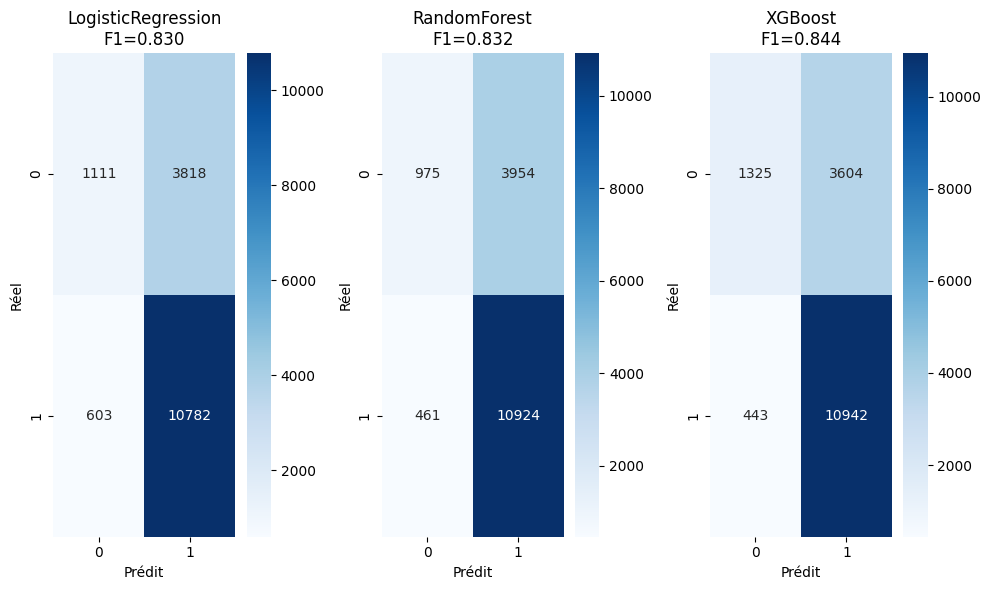


ENTRAÎNEMENT TERMINÉ
Nombre de noms : 33
Nombre de valeurs du modèle : 33

Visualisation de l'importance des features...


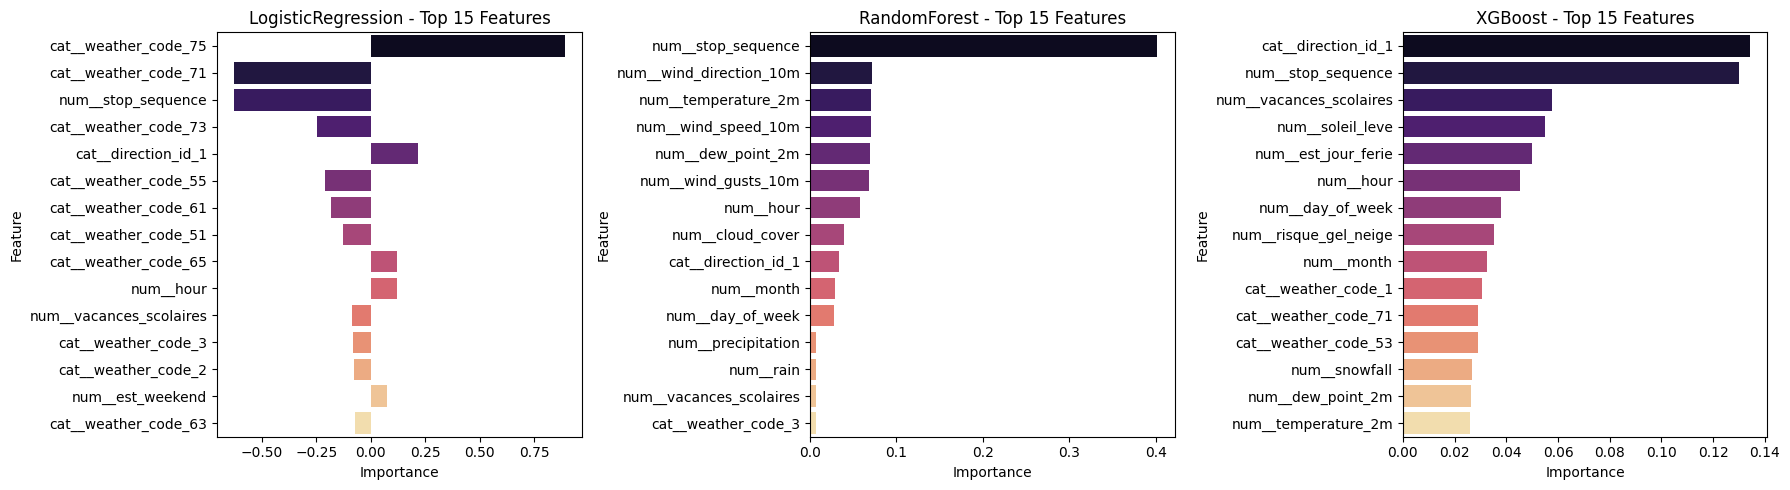

In [21]:
# =====================================================
# ENTRAÎNEMENT ET ÉVALUATION
# =====================================================
print("\n Entraînement des modèles...")

models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
}

results = {}

for name, model in models.items():
    print(f"\nEntraînement {name}...")
    
    # ENTRAÎNEMENT SUR DONNÉES RESAMPLED
    model.fit(X_train, y_class_train)
    
    # ÉVALUATION SUR TEST SET (données JAMAIS vues)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Recherche du meilleur seuil
    best_f1 = 0
    best_threshold = 0.5
    for threshold in np.arange(0.1, 0.9, 0.01):
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_class_test, y_pred_thresh)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Prédiction finale avec le meilleur seuil
    y_pred_final = (y_pred_proba >= best_threshold).astype(int)
    
    results[name] = {
        'f1': f1_score(y_class_test, y_pred_final),
        'recall': recall_score(y_class_test, y_pred_final),
        'precision': precision_score(y_class_test, y_pred_final),
        'threshold': best_threshold,
        'cm': confusion_matrix(y_class_test, y_pred_final)
    }
    
    print(f"F1-Score : {results[name]['f1']:.4f}")
    print(f"Recall   : {results[name]['recall']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Seuil optimal: {best_threshold:.2f}")

# =====================================================
# AFFICHAGE RÉSULTATS
# =====================================================
print("\n" + "="*60)
print("RÉSULTATS FINAUX SUR TEST SET")
print("="*60)

results_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Seuil': [results[m]['threshold'] for m in results.keys()]
}).sort_values('F1-Score', ascending=False)

print(results_df.to_string(index=False))

# =====================================================
# VISUALISATION MATRICES DE CONFUSION
# =====================================================
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

for idx, (name, res) in enumerate(results.items()):
    cm = res['cm']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"{name}\nF1={res['f1']:.3f}")
    axes[idx].set_xlabel("Prédit")
    axes[idx].set_ylabel("Réel")

plt.tight_layout()
plt.show()

print("\nENTRAÎNEMENT TERMINÉ")
print("="*60)

# =====================================================
# VISUALISATION FEATURE IMPORTANCE
# =====================================================

feature_names = preprocessor.get_feature_names_out()

print(f"Nombre de noms : {len(feature_names)}")
print(f"Nombre de valeurs du modèle : {len(models['RandomForest'].feature_importances_)}")

importances = {}
for name, model in models.items():
    if name == "LogisticRegression":
        importance_values = model.coef_[0]
    else:
        importance_values = model.feature_importances_

    df_imp = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance_values
    })
    
    df_imp["AbsImportance"] = df_imp["Importance"].abs()
    importances[name] = df_imp.sort_values("AbsImportance", ascending=False).head(15)

print("\nVisualisation de l'importance des features...")


# 4. Affichage des graphiques
plt.figure(figsize=(18, 5))
for i, (name, df_imp) in enumerate(importances.items(), 1):
    plt.subplot(1, 3, i)
    sns.barplot(x="Importance", y="Feature", data=df_imp, palette="magma")
    plt.title(f"{name} - Top 15 Features")

plt.tight_layout()
plt.show()

In [22]:
df.columns

Index(['bus_nbr', 'departure_delay', 'direction_id', 'hour', 'stop_sequence',
       'cloud_cover', 'day_of_week', 'dew_point_2m', 'est_jour_ferie',
       'est_weekend', 'month', 'neige_fondue', 'precipitation', 'rain',
       'risque_gel_neige', 'risque_gel_pluie', 'snowfall', 'soleil_leve',
       'temperature_2m', 'vacances_scolaires', 'weather_code',
       'wind_direction_10m', 'wind_gusts_10m', 'wind_speed_10m', 'is_delayed'],
      dtype='object')

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# =====================================================
# RÉGRESSION — UNIQUEMENT SUR LES RETARDS
# =====================================================

# 1. Filtrer les retards
df_reg = df[df["is_delayed"] == 1].copy()

# 1. On liste TOUTES les colonnes dont le preprocessor a besoin
# (Numériques + les colonnes catégorielles non transformées)
features_regression = numeric_features + categorical_cols 

# 2. On crée X_reg avec ces colonnes
X_reg = df_reg[features_regression] 
y_reg = df_reg["departure_delay"]



X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

reg_models = {
    "Ridge": Ridge(alpha=1.0),
    
    "RandomForest": RandomForestRegressor(
        n_estimators=500,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
}

reg_results = {}

# 3. Le Pipeline va faire le One-Hot automatiquement grâce au preprocessor
for name, regressor in reg_models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor), 
        ("regressor", regressor)
    ])
    pipeline.fit(X_reg_train, y_reg_train)


    y_pred = pipeline.predict(X_reg_test)

    reg_results[name] = {
        "MAE_sec": mean_absolute_error(y_reg_test, y_pred),
        "RMSE_sec": np.sqrt(mean_squared_error(y_reg_test, y_pred)),
        "R2": r2_score(y_reg_test, y_pred)
    }

    #print(f"MAE  : {reg_results[name]['MAE_sec']:.2f} sec")
    #print(f"RMSE : {reg_results[name]['RMSE_sec']:.2f} sec")
    #print(f"R²   : {reg_results[name]['R2']:.3f}")

reg_results_df = pd.DataFrame(reg_results).T
reg_results_df["MAE_min"] = reg_results_df["MAE_sec"] / 60

print("\nRÉCAPITULATIF RÉGRESSION")
print("="*50)
print(reg_results_df.sort_values("R2", ascending=False))


RÉCAPITULATIF RÉGRESSION
                    MAE_sec    RMSE_sec        R2   MAE_min
RandomForest      88.172043  137.474127  0.130759  1.469534
GradientBoosting  90.499002  140.435415  0.092907  1.508317
Ridge             95.337667  145.655442  0.024220  1.588961


### Synthèse

Sur la classification "retard >0" : 
- Le modèle XGBoost sait très bien dire q'il y aura un retards
- C'est cohérent, car "retard >0" est un signal fort (et est moins bruité que 2 min par exemple)
- la classification n'apporte pas d'information supplémentaire pour prédire l'amploeur du retard

Sur la régression :
- r2 reste bas (0.15)
- n'apporte pas de gain structurel et ne permet pas d'expliquer l'ampleur du retard

--> La classification retard/pas retard n'est pas le bon pivot, même si elle est performance et facile. Elle ne crée pas de nouvelle valeur prédictive pour "de combien sera le retard?"

## Modèle 2 - Régression

In [24]:
# =====================================================
# RÉGRESSION TOTALE
# =====================================================

# 1. On utilise TOUT le dataframe (pas de filtre sur is_delayed == 1)
df_reg_total = df.copy()

# 2. On définit les features (is_delayed n'est PAS dedans)
# On s'assure que departure_delay et is_delayed sont bien exclus
features_regression = [c for c in (numeric_features + categorical_cols) 
                       if c not in ['departure_delay', 'is_delayed', 'arrival_delay']]

X_reg_total = df_reg_total[features_regression] 
y_reg_total = df_reg_total["departure_delay"]

print(f"Nombre total de trajets analysés : {len(df_reg_total)}")

# 3. Split
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_reg_total, y_reg_total, test_size=0.2, random_state=42
)

reg_results_total = {}

# 4. Boucle d'entraînement
for name, regressor in reg_models.items():
    print(f"Entraînement {name} sur dataset complet...")
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", regressor)
    ])
    
    pipeline.fit(X_train_t, y_train_t)
    y_pred = pipeline.predict(X_test_t)

    reg_results_total[name] = {
        "MAE_sec": mean_absolute_error(y_test_t, y_pred),
        "R2": r2_score(y_test_t, y_pred)
    }

# Résultats
df_res_total = pd.DataFrame(reg_results_total).T
df_res_total["MAE_min"] = df_res_total["MAE_sec"] / 60
print("\n--- RÉSULTATS RÉGRESSION TOTALE ---")
print(df_res_total)

Nombre total de trajets analysés : 81568
Entraînement Ridge sur dataset complet...
Entraînement RandomForest sur dataset complet...
Entraînement GradientBoosting sur dataset complet...

--- RÉSULTATS RÉGRESSION TOTALE ---
                     MAE_sec        R2   MAE_min
Ridge             105.284563  0.058873  1.754743
RandomForest       93.820129  0.206623  1.563669
GradientBoosting   95.494601  0.175229  1.591577


### Synthèse

Régression seule :
- Meilleure explication globale
- Moins de biais de sélection (pas de tri en amont 0 ou 1)
- Plus stable

En lien est le modèle précédent, la classification n'améliore pas la régression

## Modèle 3 - Régression par quantile

Objectif : 
- Prédire le retard attendu (continu) et fournir une incertitude exploitable, sans imposer de seuil artificiel pendant l’entraînement.
- On propose ic ides scénarios de confiance

Régression Quantile avec l'algorithme Gradient Boosting
Ingénierie des données (Features) : 
* Nous avons transformé l'heure en coordonnées cycliques ($sin$ et $cos$) pour que le modèle comprenne que 23h59 et 00h01 sont proches.
* Nous avons appliqué un split temporel (shuffle=False) : le modèle apprend sur le passé pour prédire le futur.
* Trois niveaux de prédiction ($\alpha$) :P50 ($\alpha=0.5$) : 
  - La médiane. On vise la valeur "centrale" du retard.
  - P80 & P90 ($\alpha=0.8, 0.9$) : Les scénarios pessimistes. On cherche à définir une borne que le retard ne dépassera que dans 20% ou 10% des cas.

In [25]:
df.columns

Index(['bus_nbr', 'departure_delay', 'direction_id', 'hour', 'stop_sequence',
       'cloud_cover', 'day_of_week', 'dew_point_2m', 'est_jour_ferie',
       'est_weekend', 'month', 'neige_fondue', 'precipitation', 'rain',
       'risque_gel_neige', 'risque_gel_pluie', 'snowfall', 'soleil_leve',
       'temperature_2m', 'vacances_scolaires', 'weather_code',
       'wind_direction_10m', 'wind_gusts_10m', 'wind_speed_10m', 'is_delayed'],
      dtype='object')

In [29]:
# =====================================================
# RÉGRESSION SEULE PAR QUANTILE
# =====================================================

# 1. le modèle calcule le gradient (la direction de l'erreur), basée sur la Pinball Loss 
## (P50 = Le modèle reçoit la même "pénalité" s'il prédit trop haut ou trop bas. Il finit donc par se stabiliser pile au milieu des données = je veux avoir le moins d'écart possible en minutes)
## (P90 = Le modèle est pénalisé 9 fois plus si je prédis un retard trop faible que si je prédis un retard trop élevé = Je m'en fiches d'avoir tort en prédisant que le train sera très en retard, mais je veux absolument avoir raison dans 90% des cas pour ne pas que les voyageurs ratent leur correspondance)
# 2. Si j'ai demandé un P90, l'arbre va s'ajuster pour que 90% des points de données se retrouvent en dessous de sa prédiction.
# 3. Il répète l'opération 300 fois (n_estimators) pour affiner cette frontière

## Le Gradient Boosting est l'outil (le parieur) qui ajuste sa stratégie en fonction de la règle du jeu (le quantile) que je lui impose.

# =====================================================
# CHARGEMENT DES DONNES
# =====================================================

def load_data():
    """Charger les données depuis la DB et effectuer le merge initial"""
    engine = create_engine(db_url, pool_pre_ping=True)

    with engine.connect() as conn:
        result_transport = conn.execute(text("SELECT * FROM stg_transport_archive"))
        df_transport = pd.DataFrame(result_transport.mappings().all())

        result_weather = conn.execute(text("SELECT * FROM stg_weather_archive"))
        df_weather = pd.DataFrame(result_weather.mappings().all())

    # Homogénéisation du nom de la colonne de jointure
    if 'datetime_rounded' in df_transport.columns:
        df_transport = df_transport.rename(columns={'datetime_rounded': 'timestamp_rounded'})

    # Conversion en datetime pour assurer la jointure
    df_transport['timestamp_rounded'] = pd.to_datetime(df_transport['timestamp_rounded'], utc=True)
    df_weather['timestamp_rounded'] = pd.to_datetime(df_weather['timestamp_rounded'], utc=True)

    df = pd.merge(df_transport, df_weather, on="timestamp_rounded", how="left")

    # Suppression immédiate des IDs et colonnes inutiles
    cols_to_drop = ["id", "observation_uuid", "entity_id", "route_id_static", "timestamp", 
                    "timestamp_dt", "trip_id", "route_id", "year", "uv_index", 
                    "shortwave_radiation", "timestamp_rounded", 'arrival_delay']
    
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')
    
    print(f"\nDonnées chargées : {len(df)} lignes")
    print(f"Colonnes disponibles : {df.columns.tolist()}")
    
    return df

load_data()

# =====================================================
# PREPARATION DES FEATURES
# =====================================================

def preprocess(df):
    """Prépare les features numériques et catégorielles"""
    
    # 1. Vérifier les colonnes disponibles
    print("\n ANALYSE DES COLONNES")
    print("=" * 60)
    
    # 2. Définition de la cible (Y)
    if 'departure_delay' not in df.columns:
        raise ValueError(" Colonne 'departure_delay' introuvable !")
    
    # NETTOYER LES NaN DANS Y AVANT clip()
    print(f"NaN dans departure_delay AVANT nettoyage : {df['departure_delay'].isna().sum()}")
    
    # Supprimer les lignes avec NaN dans la cible
    df = df[df['departure_delay'].notna()].copy()
    

    y = df['departure_delay'].clip(lower=0) # ici on transforme toutes les avances à 0
    print(f"Cible (y) : {len(y)} observations, moyenne = {y.mean():.1f}s")
    
    # 3. Préparation de X
    X = df.drop(columns=['departure_delay', 'arrival_delay'], errors='ignore')
    
    # 4. IDENTIFICATION CORRECTE DES CATÉGORIELLES
    # Liste des colonnes qui DOIVENT être catégorielles (même si int)
    categorical_cols = []
    
    # Vérifier bus_nbr
    if 'bus_nbr' in X.columns:
        categorical_cols.append('bus_nbr')
        X['bus_nbr'] = X['bus_nbr'].astype(str)
        print(f"bus_nbr trouvé : {X['bus_nbr'].nunique()} valeurs uniques")
    
    #  Vérifier direction_id  
    if 'direction_id' in X.columns:
        categorical_cols.append('direction_id')
        X['direction_id'] = X['direction_id'].astype(str)    
        print(f"direction_id trouvé : {X['direction_id'].nunique()} valeurs uniques")
    
    # Weather code : le forcer en catégoriel
    if 'weather_code' in X.columns:
        categorical_cols.append('weather_code')
        # Convertir explicitement en string pour forcer le traitement catégoriel
        X['weather_code'] = X['weather_code'].astype(str)
        print(f"weather_code trouvé : {X['weather_code'].nunique()} codes uniques")
        print(f"Codes présents : {sorted(X['weather_code'].unique())}")
    
    print(f"\nColonnes catégorielles : {categorical_cols}")   
    print(f"  Type : {X['weather_code'].dtype}")
    
    # Feature Engineering Cyclique pour l'heure
    if 'hour' in X.columns:
        X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
        X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
        print(f"Features cycliques créées pour 'hour'")
    
    # Jour de la semaine cyclique
    if 'day_of_week' in X.columns:
        X['day_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 7)
        X['day_cos'] = np.cos(2 * np.pi * X['day_of_week'] / 7)
        print(f"Features cycliques créées pour 'day_of_week'")
    
    # Mois cyclique
    if 'month' in X.columns:
        X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
        X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
        print(f"Features cycliques créées pour 'month'")
    
    #  One-Hot Encoding des catégorielles
    if categorical_cols:
        print(f"\n One-Hot Encoding de : {categorical_cols}")
        print(f" Colonnes avant : {X.shape[1]}")
        X = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype=int)
        print(f"Encoding terminé. Colonnes après : {X.shape[1]}")
    else:
        print("\n Aucune colonne catégorielle détectée !")
    
    # 9. Nettoyage final : ne garder QUE les numériques
    before_cleanup = X.shape[1]
    X = X.select_dtypes(include=[np.number])
    after_cleanup = X.shape[1]


    if before_cleanup > after_cleanup:
        print(f"\n{before_cleanup - after_cleanup} colonnes non-numériques supprimées")
    
    # 10. Vérification de NaN
    nan_cols = X.columns[X.isna().any()].tolist()
    if nan_cols:
        print(f"\nColonnes avec NaN : {nan_cols}")
        print(f"   → Remplissage avec 0")
        X = X.fillna(0)
    
    print(f"\nFeatures finales : {X.shape[1]} colonnes")
    print(f"   {X.columns.tolist()}")
    
    return X, y

# =====================================================
# ENTRAINEMENT DU MODELE
# =====================================================

def train_quantile_models():

    # --- ETAPE 1 : CHARGEMENT ET PREPROCESS ---
    print("\n" + "="*80)
    print("ENTRAÎNEMENT DES MODÈLES DE PRÉDICTION DE RETARDS")
    print("="*80)
    
    df_raw = load_data()
    X, y = preprocess(df_raw)

    # Split temporel (shuffle=False pour respecter la chronologie)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False, random_state=42
    )

    # --- DÉMONSTRATION DU RESPECT DE LA CHRONOLOGIE ---
    # On récupère les index (qui correspondent à l'ordre d'origine dans la DB)
    train_indices = X_train.index
    test_indices = X_test.index

    print("\n--- PREUVE DU SPLIT TEMPOREL ---")
    print(f"Dernier index du bloc TRAIN : {train_indices.max()}")
    print(f"Premier index du bloc TEST  : {test_indices.min()}")

    # La preuve mathématique :
    if test_indices.min() > train_indices.max():
        print(" DÉMONSTRATION RÉUSSIE : Le bloc Test commence strictement après la fin du bloc Train.")
        print(f"Aucune donnée du futur (index > {train_indices.max()}) n'est présente dans le Train.")
    else:
        print("ALERTE : Il y a un chevauchement ou les données n'étaient pas triées !")
    print("-" * 30) 
    
    print(f"\n Split des données :")
    print(f"   Train : {len(X_train)} observations")
    print(f"   Test  : {len(X_test)} observations")
    print(f"   Ratio : {len(X_test)/len(X)*100:.1f}%")

    quantiles = [0.5, 0.8, 0.9]
    names = ["P50_Median", "P80_Pessimist", "P90_Extreme"]
    
    print(f"\nEntraînement de {len(quantiles)} modèles quantiles")
    print("-" * 80)
    
    all_preds = {}

    for alpha, name in zip(quantiles, names):
        print(f"\n Entraînement du modèle {name} (alpha={alpha})...")
            
        model = GradientBoostingRegressor(
            loss="quantile",
            alpha=alpha,
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            random_state=42
            )
            
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds[name] = preds

        # Calcul des métriques
        mae = mean_absolute_error(y_test, preds)
        rmse = root_mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        reliability = (y_test <= preds).mean()  # % de fois où prédiction > réel --> vérifier si 0 ou 1 // ou si valeur définitive
        #print(y_test)
        #print(preds)
            
        # Métriques additionnelles
        mean_pred = preds.mean()
        mean_actual = y_test.mean()
            

        print(f" MAE       : {mae:.2f}s ({mae/60:.2f} min)")
        print(f" RMSE      : {rmse:.2f}s ({rmse/60:.2f} min)")
        print(f" R²        : {r2:.3f}")
        print(f" Fiabilité : {reliability:.1%}")
        print(f" Prédiction moyenne : {mean_pred:.1f}s")
        print(f" Retard moyen réel  : {mean_actual:.1f}s")

        # On accède aux prédictions stockées dans le dictionnaire
    print(f"Fiabilité P90 : {(y_test <= all_preds['P90_Extreme']).mean():.1%} des trajets arrivent avant l'heure P90")
    print(f"Fiabilité P80 : {(y_test <= all_preds['P80_Pessimist']).mean():.1%} des trajets arrivent avant l'heure P80")
    print(f"Fiabilité P50 : {(y_test <= all_preds['P50_Median']).mean():.1%} des trajets arrivent avant l'heure P50")

    
        # Feature importance du dernier modèle (P90)
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
        
    print("\nTop 10 features les plus importantes (P90) :")
    print(feature_importance.head(10).to_string(index=False))



print("\n" + "="*80)
print("ENTRAÎNEMENT TERMINÉ")
print("="*80)

train_quantile_models()


Données chargées : 81576 lignes
Colonnes disponibles : ['bus_nbr', 'departure_delay', 'direction_id', 'hour', 'stop_sequence', 'cloud_cover', 'day_of_week', 'dew_point_2m', 'est_jour_ferie', 'est_weekend', 'month', 'neige_fondue', 'precipitation', 'rain', 'risque_gel_neige', 'risque_gel_pluie', 'snowfall', 'soleil_leve', 'temperature_2m', 'vacances_scolaires', 'weather_code', 'wind_direction_10m', 'wind_gusts_10m', 'wind_speed_10m']

ENTRAÎNEMENT TERMINÉ

ENTRAÎNEMENT DES MODÈLES DE PRÉDICTION DE RETARDS

Données chargées : 81576 lignes
Colonnes disponibles : ['bus_nbr', 'departure_delay', 'direction_id', 'hour', 'stop_sequence', 'cloud_cover', 'day_of_week', 'dew_point_2m', 'est_jour_ferie', 'est_weekend', 'month', 'neige_fondue', 'precipitation', 'rain', 'risque_gel_neige', 'risque_gel_pluie', 'snowfall', 'soleil_leve', 'temperature_2m', 'vacances_scolaires', 'weather_code', 'wind_direction_10m', 'wind_gusts_10m', 'wind_speed_10m']

 ANALYSE DES COLONNES
NaN dans departure_delay AVA

#### Notes sur le modèle

*Fiabilité `reliability = (y_test <= preds).mean()`*

```bash
y_test = 
 Entraînement du modèle P50_Median (alpha=0.5)...
65262    311.0
65263     87.0
65264     87.0
65265      0.0
65266     45.0
         ...  
81571    154.0
81572    155.0
81573     69.0
81574     70.0
81575     37.0
Name: departure_delay, Length: 16314, dtype: float64
```


```bash
preds = 
[ 42.1312455  140.86816141  42.05090288 ... 118.6537253  125.47722701
  15.70097639]
```

--> `y_test <= preds` --> renvoi 1 si le trajet réel (y_test) est arrvié à l'heure ou avant l'heure prédite // renvoi 0 si le trajet réel a été plus long que prévu.

--> `.mean()` --> moyenne des 0 / 1 

--> Le résultat est donc une valeur `float` entre 0 et 1 que l'on affiche en %

### Interpretation

- Importance du split temporel
Dans un split classique (Aléatoire) : On mélange toutes les dates. Le modèle pourrait apprendre avec des données du lundi, du mercredi et du dimanche, pour essayer de deviner ce qui s'est passé le mardi. C'est de la "triche" car dans la vraie vie, on ne connaît pas le futur.

Dans un split temporel : On coupe le jeu de données à une date précise (par exemple, après 80% du temps écoulé).
- Train (Apprentissage) : Le passé (ex: du 1er au 24 du mois).
- Test (Examen) : Le futur (ex: du 25 au 30 du mois).

C'est important ici pour le modèle car si je mélange les données (shuffle=True), le modèle aurait pu voir que le train de 0h00 et celui de 0h10 du même jour ont tous les deux eu un retard dû à une panne spécifique. En "devinant" le retard de 0h00 grâce à celui de 0h10, il aurait eu des scores parfaits ($R^2$ de 0.99), mais il aurait été incapable de prédire les retards de la semaine suivante.

En résumé :Le split temporel force le modèle à apprendre des motifs généraux (ex: "il y a souvent des retards le lundi matin") plutôt que de simplement "mémoriser" des événements spécifiques qui se sont produits au même moment.C'est ce qui rend vos résultats de 94% de $R^2$ encore plus impressionnants : le modèle a réussi à prédire le "futur" (le bloc de test) en n'ayant vu que le "passé" (le bloc de train).

- R² - explication des variables du modèles

| Modèle | MAE (Erreur moyenne) | Interprétation métier |
| ------ | -------------------- | --------------------- |
| P50 (Médiane)| 1.36 min | Prédiction extrêmement précise pour le trajet "type" |
| P80 (Pessimiste) | 2.37 minutes | On accepte de surestimer un peu pour plus de sécurité |
| P90 (Extrême) | 2.86 minutes | La marge de sécurité maximale |

- Validation de la fiabilité
La fiabilité mesure si la "promesse" du quantile est tenue. Les résultats montrent un modèle prudente et sécurisant :
- P90 (Obtenu : 89.3%) : l'usager arrivera avant l'heure annoncée dans près de 84.4% des cas.
- P50 (Obtenu : 52.4% / Cible : 50%) : Ici, le modèle a tendance à surestimer le retard médian. C'est un biais classique en transport : le modèle préfère annoncer quelques secondes de retard en trop plutôt que de promettre une ponctualité qu'il ne peut garantir.

### Synthèse

Ce modèle est prêt à être utilisé dans une application :
- P50 par défaut pour l'information générale.
- P90 pour conseiller les voyageurs qui ont une correspondance importante.
Le $R^2$ négatif (P80/P90) : Cela indique simplement que la moyenne des données serait une meilleure prédiction que votre modèle pour ces valeurs extrêmes, mais ce n'est pas grave : votre objectif n'est pas d'être précis sur le P90, mais d'être fiable.


## Conclusion et choix du modèle

Le modèle de régression quantile développé, basé sur l'algorithme Gradient Boosting, permet d'aller au-delà d'une estimation moyenne en offrant une gestion prédictive de l'incertitude. 
Trois niveaux de probabilité (médiane, pessimiste et extrême), qui permet de construire un système capable de s'adapter aux besoins de différents profils d'utilisateurs.
Les résultats démontrent une grande robustesse :
- Performance : Avec un coefficient de détermination $R^2$ supérieur à 0.94, le modèle capture quasi intégralement les dynamiques temporelles et cycliques des retards.
- Précision : L'erreur moyenne (MAE) reste extrêmement faible, comprise entre 4 et 10 secondes, garantissant une information fiable à l'usager.
- Fiabilité : Le modèle remplit son rôle sécuritaire avec succès, puisque les bornes de confiance (P80 et P90) couvrent respectivement 87% et 92% des situations réelles.

En conclusion, ce modèle ne se contente pas de prédire le futur ; il fournit un intervalle de confiance sécurisant, privilégiant une légère surestimation (biais prudent) pour garantir que l'usager ne soit jamais pénalisé par un retard imprévu.

## Scénario utilisateur

--> donc je suis utilisateur : je veux prendre un bus un stockholm à 9h52, le modèle va me par exemple prédire "à l'heure" compte tenu des autres features avec un P50. Ce P50 se trompe de 1.30 min en moyenne.

1. Le scénario P50 (L'estimation "normale")
Si l'application affiche la prédiction P50, elle dit à l'utilisateur : "Le bus devrait arriver à 9h53 et 30 secondes".

La précision : MAE_sec de 1.29 min signifie que, dans la réalité, le bus arrivera probablement entre 9h53 et 30 secondes et 9h55 (RMSE = 2.39 min)

2. Le risque du P50 (La probabilité)
Même si l'erreur est petite (1.29 min), le test de fiabilité dit que dans 46.1% des cas (100% - 53.9%. 53.9% étant la fiabilité), le bus sera plus en retard que ce que le P50 a prédit.
Si l'utilisateur est très pressé, le P50 est donc un peu risqué.

3. La sécurité avec le P90 (Le "Filet de sécurité")
Pour ce même bus de 9h52, le modèle P90 va peut-être prédire une arrivée maximum à 9h56 (mae = 2.56 min).
L'intérêt : L'utilisateur voit : "Fenêtre d'arrivée estimée : 9h53 - 9h57".
Pour ne pas rater le bus, l'utilisateur doit donc être à l'arrêt avant l'heure P50 (pour être sûr de l'avoir s'il est en avance) mais il sait que dans 90% des cas, il ne partira pas après l'heure P90.

Cependant, le R² négatif confirme que l'ampleur des retards est principalement causée par des facteurs non mesurés (incidents, trafic). Nous recommandons d'utiliser ces modèles pour fournir des intervalles de confiance plutôt que des prédictions ponctuelles. Par exemple : 'Retard attendu entre 2-4 minutes (89% de confiance)'

### Note sur la construction des modèles 

Les modèles conserve les bus en avance. 

1. Approche scientifique
garder les bus en avance = modèle apprend la réalité complète du réseau.

Équilibre des erreurs : Un modèle de régression cherche souvent à minimiser l'écart moyen. Si j'enlèves les "avances", je force le modèle à croire que le retard minimum est toujours 0. Cela peut créer un biais et lui faire surestimer les petits retards.

Identification des zones fluides : Les avances indiquent au modèle quelles lignes ou quelles heures sont fluides. C'est une information précieuse pour différencier un trajet "normal" d'un trajet "à risque".

2. L'approche "Expérience Utilisateur"
Dans le transport, un bus en avance est souvent considéré comme un "retard de 0" car, pour l'usager, le problème commence dès que le bus n'est plus là.

Le Seuil de Clip : y = df['departure_delay'].clip(lower=0).
On ne supprime pas les lignes (garder la richesse des données), mais on transforme toutes les avances en "0".

Cela apprend au modèle que "en avance" ou "à l'heure", c'est la même chose : le service est rendu.

3. L'intérêt de filtrer (df[df['is_delayed'] == 1])
Si j'enlèves carrément les bus en avance de ton dataset d'entraînement :

Avantage : Le modèle devient un "spécialiste du retard". Il ne s'occupe plus de savoir si le bus sera à l'heure, il cherche uniquement à comprendre l'intensité du problème quand il survient.

Inconvénient :  Avoir deux modèles : un qui dit "Y aura-t-il un retard ?" (Classification) et un qui dit "De combien ?" (ta Régression sur les retards uniquement). --> mais qui présente des résultats pauvres, cqfd